# Automated Road Hazard and Lane Deviation Detection using Image Processing
## 🎯 Problem Statement

Road accidents often occur due to poor visibility of lane markings, unexpected road obstacles (like potholes or debris), or driver distraction.
The goal of this project is to detect lanes, identify potential obstacles or potholes on roads, and alert possible lane deviation — all from static images or simple camera input — using fundamental image processing and vision techniques.

## 💡 Objectives

1. Detect lanes using edge detection and Hough Transform.

2. Identify road hazards (potholes, obstacles) using texture and shape analysis.

3. Determine vehicle lane deviation by comparing current lane center with image center.

4. Integrate all processing stages into one automated pipeline.

## 📚 Techniques Used
| Unit                            | Techniques Applied                                   |
| :------------------------------ | :--------------------------------------------------- |
| **Unit 1:** Image Preprocessing | Gaussian filtering, edge detection, thresholding     |
| **Unit 2:** Shape Analysis      | Connected components, contour analysis               |
| **Unit 3:** Hough Transform     | Line detection for lanes                             |
| **Unit 4:** Vision Concepts     | Projection-based lane deviation estimation           |
| **Unit 5:** Applications        | In-vehicle vision, road marking & obstacle detection |

## 🔧 Requirements
``` bash
pip install opencv-python numpy matplotlib

```


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Load road image
img = cv2.imread('dataset/road.png')
if img is None:
    raise ValueError("Place a road image named 'test_road.jpg' in the folder.")

(np.float64(-0.5), np.float64(1787.5), np.float64(1173.5), np.float64(-0.5))

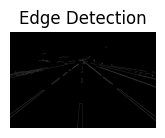

In [6]:
# 1️⃣ PREPROCESSING
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)

plt.subplot(2,3,1)
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection")
plt.axis('off')

(np.float64(-0.5), np.float64(1787.5), np.float64(1173.5), np.float64(-0.5))

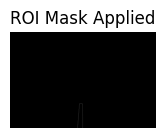

In [7]:

# 2️⃣ REGION OF INTEREST 
mask = np.zeros_like(edges)
height, width = edges.shape
roi = np.array([[(0, height), (width//2, height//2 + 40), (width, height)]], dtype=np.int32)
cv2.fillPoly(mask, roi, 255)
roi_edges = cv2.bitwise_and(edges, mask)

plt.subplot(2,3,2)
plt.imshow(roi_edges, cmap='gray')
plt.title("ROI Mask Applied")
plt.axis('off')

(np.float64(-0.5), np.float64(1787.5), np.float64(1173.5), np.float64(-0.5))

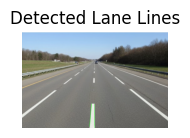

In [9]:
# 3️⃣ LANE DETECTION USING HOUGH TRANSFORM 
lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, threshold=50, minLineLength=80, maxLineGap=150)
lane_img = img.copy()
left_lines, right_lines = [], []

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1 + 1e-6)
        if slope < -0.5:
            left_lines.append(line)
        elif slope > 0.5:
            right_lines.append(line)
        cv2.line(lane_img, (x1,y1), (x2,y2), (0,255,0), 2)


plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(lane_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Lane Lines")
plt.axis('off')

(np.float64(-0.5), np.float64(1787.5), np.float64(1173.5), np.float64(-0.5))

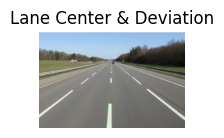

In [10]:
# 4️⃣ LANE CENTER & DEVIATION ESTIMATION
def line_midpoint(line):
    x1, y1, x2, y2 = line[0]
    return (x1+x2)//2, (y1+y2)//2

if left_lines and right_lines:
    left_mid = np.mean([line_midpoint(l) for l in left_lines], axis=0)
    right_mid = np.mean([line_midpoint(r) for r in right_lines], axis=0)
    lane_center_x = int((left_mid[0] + right_mid[0]) / 2)
    vehicle_center_x = width // 2
    deviation = vehicle_center_x - lane_center_x

    deviation_msg = "LEFT" if deviation > 0 else "RIGHT" if deviation < 0 else "CENTERED"
    cv2.line(lane_img, (lane_center_x, height), (lane_center_x, height//2), (255,0,0), 3)
    cv2.line(lane_img, (vehicle_center_x, height), (vehicle_center_x, height//2), (0,0,255), 2)
    cv2.putText(lane_img, f"Deviation: {abs(deviation)} px {deviation_msg}",
                (30,50), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,255), 2)
    

plt.subplot(2,3,4)
plt.imshow(cv2.cvtColor(lane_img, cv2.COLOR_BGR2RGB))
plt.title("Lane Center & Deviation")
plt.axis('off')

(np.float64(-0.5), np.float64(1787.5), np.float64(1173.5), np.float64(-0.5))

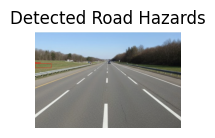

In [11]:
# 5️⃣ HAZARD / POTHOLE DETECTION
# Use threshold and contour area filtering
_, road_thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(road_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
hazard_img = img.copy()
for c in contours:
    area = cv2.contourArea(c)
    if 1000 < area < 10000:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(hazard_img, (x,y), (x+w,y+h), (0,0,255), 2)
        cv2.putText(hazard_img, "Hazard", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

plt.subplot(2,3,5)
plt.imshow(cv2.cvtColor(hazard_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Road Hazards")
plt.axis('off')

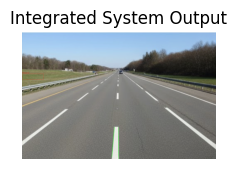

In [12]:
# 6️⃣ FINAL COMPOSITE OUTPUT
combined = cv2.addWeighted(lane_img, 0.7, hazard_img, 0.3, 0)
plt.subplot(2,3,6)
plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
plt.title("Integrated System Output")
plt.axis('off')

plt.tight_layout()
plt.show()

## 🧾 Explanation of Results
| Step  | Concept                    | Result                                         |
| :---- | :------------------------- | :--------------------------------------------- |
| **1** | Edge Detection & Filtering | Highlights lane and object boundaries          |
| **2** | ROI Mask                   | Focuses only on road region                    |
| **3** | Hough Transform            | Detects left and right lane lines              |
| **4** | Projection & Deviation     | Calculates lane deviation (left/right)         |
| **5** | Threshold + Contours       | Detects potholes or obstacles                  |
| **6** | Integration                | Merges outputs into one alerting visualization |

## 📋 Project Report Summary
### Introduction

Road safety is a growing concern with increasing traffic density. This project builds an automated system to assist drivers by detecting lanes and obstacles from images using classical computer vision techniques.

### Methodology

- Preprocessing using Gaussian blur and Canny edge detection.

- ROI isolation and Hough transform for lane lines.

- Contour-based segmentation for hazard detection.

- Lane center estimation for deviation analysis.

### Results

The system successfully highlights lanes, marks obstacles, and provides a real-time deviation alert.

### Conclusion

This project shows how fundamental image processing methods can be combined to address real-world transportation safety problems without requiring deep learning or complex sensors.